In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from IPython.display import Markdown, display

In [2]:
def create_donut_charts(dataframes, column_names, titles=None):
    if titles is None:
        titles = column_names
        
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    # plt.show()
    return fig

In [3]:
outpath = Path('results/wallet_analysis')
outpath.mkdir(exist_ok=True)

wallet_df = pd.read_csv(Path('data/stETH token distribution  - stETH+wstETH holders.csv'))
wallet_df.loc[wallet_df.type.isna(), 'type'] = 'Other'
wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum() * 100

In [76]:
wallet_df[((wallet_df.type == 'Private') | (wallet_df.type == 'Other')) & (wallet_df.total < 3000)]

,address,stETH,wstETH,total,label,type,protocol_type,total_token_share
282,0x186a65fa0dd9da19fda28af7ce3bd3b2ce59338f,2971.136901,0.000000,2971.136901,Token Millionaire [0x186a65],Private,NaN,0.033026
284,0xa5cca85500702df341351d9fb4dfc82eb83ecd5e,0.000000,2915.419786,2915.419786,Token Millionaire [0xa5cca8],Private,NaN,0.032406
294,0xd6285a2debeebf39a55c3fe1e0ba202695983a48,2802.102969,0.000000,2802.102969,Token Millionaire [0xd6285a],Private,NaN,0.031147
297,0x3cba04009e19a27eb3033c27d0a4b04d67cdbd45,2764.989282,0.000000,2764.989282,Token Millionaire [0x3cba04],Private,NaN,0.030734
299,0x849d52316331967b6ff1198e5e32a0eb168d039d,2436.981713,292.397728,2729.379441,🤖 Gnosis: Daughter Safe [0x849d52],Private,NaN,0.030339
...,...,...,...,...,...,...,...,...
1978,0xdeccf3122d665f0e912bac602f0e28c0ae0ea8d2,0.000000,42.530401,42.530401,High Balance [0xdeccf3],Private,NaN,0.000473
1979,0x3ab2b63d7edc734da546d2c60434494dadcd8d96,0.000000,42.482581,42.482581,High Balance [0x3ab2b6],Private,NaN,0.000472
1981,0x3ecf3f579db613cf4b2f5cc465b85427ee58e3c4,0.000000,42.434110,42.434110,High Balance [0x3ecf3f],Private,NaN,0.000472
1983,0xff422eb480e02cb168586a0c85effae41555e0b0,0.000000,42.304476,42.304476,High Balance [0xff422e],Private,NaN,0.000470


In [4]:
def get_token_array(wallet_df, wallet_types):
    return np.array(
        wallet_df[wallet_df.type.isin(wallet_types)]['total_token_share'].sort_values(
            ascending=False))

def count_singles_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = np.sum(token_array > threshold)
    return count0, count0

def count_pairs_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count = np.sum((token_array[pointer1] + token_array[pointer1 + 1:]) > threshold)
        if count == 0:
            break
        count0 += count
    return count0, pointer1

def count_triplets_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count1 = 0
        for pointer2 in range(pointer1+1, n):
            count = np.sum(
                (token_array[pointer1] + token_array[pointer2] + 
                 token_array[pointer2 + 1:]
                ) > threshold 
            )
            if count == 0:
                break
            count1 += count
        if count1 == 0:
            break
        count0 += count1
    return count0, pointer1

def count_quadruplets_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count1 = 0
        for pointer2 in range(pointer1+1, n):
            count2 = 0
            for pointer3 in range(pointer2+1, n):
                count = np.sum(
                    (token_array[pointer1] + token_array[pointer2] + token_array[pointer3] +
                     token_array[pointer3 + 1:]
                    ) > threshold
                )
                if count == 0:
                    break
                count2 += count
            if count2 == 0:
                break
            count1 += count2
        if count1 == 0:
            break
        count0 += count1
    return count0, pointer1

threshold = 1.
wallet_types = ['Private']

print('thresh:', threshold)
print(count_singles_threshold(wallet_df, wallet_types, threshold))
print(count_pairs_threshold(wallet_df, wallet_types, threshold))
print(count_triplets_threshold(wallet_df, wallet_types, threshold))
print(count_quadruplets_threshold(wallet_df, wallet_types, threshold))

thresh: 1.0
(np.int64(2), np.int64(2))
(np.int64(1534), 5)
(np.int64(590413), 13)
(np.int64(152217491), 16)


In [5]:
def count_n_wallets_threshold(wallet_df, wallet_types, threshold, n):
    def recursive_count(start_idx, remaining_depth, current_sum, token_array):
        if remaining_depth == 1:
            # For the last wallet, we can directly count how many valid combinations exist
            count = np.sum((current_sum + token_array[start_idx:]) > threshold)
            return count, start_idx if count > 0 else -1
        
        count0 = 0
        last_valid_pointer = -1
        
        # Try each possible next wallet
        for pointer in range(start_idx, len(token_array) - remaining_depth + 1):
            # Recursively count combinations with this wallet
            sub_count, sub_pointer = recursive_count(
                pointer + 1, 
                remaining_depth - 1,
                current_sum + token_array[pointer],
                token_array
            )
            
            if sub_count == 0:
                break  # If no valid combinations found, later ones won't work either
                
            count0 += sub_count
            last_valid_pointer = pointer
            
        return count0, last_valid_pointer
    
    token_array = get_token_array(wallet_df, wallet_types)
    total_count, first_pointer = recursive_count(0, n, 0, token_array)
    return total_count, first_pointer

# Example usage:
# threshold = 1.7
# wallet_types = ['Private']

# print('thresh:', threshold)
# for n in range(1, 6):  # Test for groups of size 1 to 5
#     count, pointer = count_n_wallets_threshold(wallet_df, wallet_types, threshold, n)
#     print(f'Size {n} groups:', count, f'(needs first {pointer+1} wallets)')

In [6]:
from functools import lru_cache

def count_n_wallets_threshold_fast(wallet_df, wallet_types, threshold, n):
    token_array = get_token_array(wallet_df, wallet_types)
    
    # Pre-compute cumulative sums
    min_remaining_sums = np.zeros(len(token_array))
    for i in range(len(token_array) - 1, -1, -1):
        if i == len(token_array) - 1:
            min_remaining_sums[i] = token_array[i]
        else:
            min_remaining_sums[i] = min_remaining_sums[i + 1] + token_array[i]
    
    @lru_cache(maxsize=None)
    def recursive_count(start_idx, remaining_depth, current_sum):
        # Early termination if remaining wallets can't possibly sum to threshold
        remaining_needed = threshold - current_sum
        if remaining_depth * token_array[start_idx] < remaining_needed:
            return 0, -1
            
        if remaining_depth == 1:
            # Vectorized operation for the last wallet
            valid_combinations = token_array[start_idx:] + current_sum > threshold
            count = np.sum(valid_combinations)
            return count, start_idx if count > 0 else -1
        
        # Quick check if it's impossible to reach threshold with remaining wallets
        if start_idx + remaining_depth > len(token_array):  # Changed this condition
            return 0, -1
            
        # Check if the best possible combination can reach threshold
        if start_idx + remaining_depth < len(token_array):  # Added bounds check
            best_possible = current_sum + min_remaining_sums[start_idx] - min_remaining_sums[start_idx + remaining_depth]
            if best_possible <= threshold:
                return 0, -1
        
        count0 = 0
        last_valid_pointer = -1
        
        # Try each possible next wallet
        for pointer in range(start_idx, len(token_array) - remaining_depth + 1):
            # Recursively count combinations with this wallet
            sub_count, sub_pointer = recursive_count(
                pointer + 1, 
                remaining_depth - 1,
                current_sum + token_array[pointer]
            )
            
            if sub_count == 0:
                break  # If no valid combinations found, later ones won't work either
                
            count0 += sub_count
            last_valid_pointer = pointer
            
        return count0, last_valid_pointer
    
    return recursive_count(0, n, 0)

# threshold = 1.5
# wallet_types = ['Private']

# print('thresh:', threshold)
# for n in range(1, 6):  # Test for groups of size 1 to 5
#     count, pointer = count_n_wallets_threshold(wallet_df, wallet_types, threshold, n)
#     print(f'Size {n} groups:', count, f'(needs first {pointer+1} wallets)')

In [7]:
from numba import jit, float64, int64

@jit(nopython=True)
def recursive_count_numba(token_array, min_remaining_sums, threshold, start_idx, remaining_depth, current_sum):
    # Early termination if remaining wallets can't possibly sum to threshold
    remaining_needed = threshold - current_sum
    if remaining_depth * token_array[start_idx] < remaining_needed:
        return 0, -1
        
    if remaining_depth == 1:
        # Count valid combinations for the last wallet
        count = 0
        for i in range(start_idx, len(token_array)):
            if current_sum + token_array[i] > threshold:
                count += 1
        return count, start_idx if count > 0 else -1
    
    # Quick check if it's impossible to reach threshold with remaining wallets
    if start_idx + remaining_depth - 1 >= len(token_array):
        return 0, -1
        
    # Check if the best possible combination can reach threshold
    best_possible = current_sum + min_remaining_sums[start_idx] - min_remaining_sums[start_idx + remaining_depth]
    if best_possible <= threshold:
        return 0, -1
    
    count0 = 0
    last_valid_pointer = -1
    
    # Try each possible next wallet
    for pointer in range(start_idx, len(token_array) - remaining_depth + 1):
        # Recursively count combinations with this wallet
        sub_count, sub_pointer = recursive_count_numba(
            token_array,
            min_remaining_sums,
            threshold,
            pointer + 1,
            remaining_depth - 1,
            current_sum + token_array[pointer]
        )
        
        if sub_count == 0:
            break  # If no valid combinations found, later ones won't work either
            
        count0 += sub_count
        last_valid_pointer = pointer
        
    return count0, last_valid_pointer

def count_n_wallets_threshold_numba(wallet_df, wallet_types, threshold, n):
    token_array = get_token_array(wallet_df, wallet_types)
    
    # Pre-compute cumulative sums
    min_remaining_sums = np.zeros(len(token_array), dtype=np.float64)
    for i in range(len(token_array) - 1, -1, -1):
        if i == len(token_array) - 1:
            min_remaining_sums[i] = token_array[i]
        else:
            min_remaining_sums[i] = min_remaining_sums[i + 1] + token_array[i]
    
    return recursive_count_numba(token_array, min_remaining_sums, threshold, 0, n, 0.0)

# # Example usage:
# threshold = 1.
# wallet_types = ['Private']

# print('thresh:', threshold)
# for n in range(1, 6):  # Test for groups of size 1 to 5
#     count, pointer = count_n_wallets_threshold_numba(wallet_df, wallet_types, threshold, n)
#     print(f'Size {n} groups:', count, f'(needs first {pointer+1} wallets)')

In [19]:
from numba import jit, float64, int64, boolean

@jit(nopython=True)
def recursive_count_numba_optimized(token_array, min_remaining_sums, threshold, start_idx, remaining_depth, current_sum, valid_combinations):
    n = len(token_array)
    
    # Early termination if remaining wallets can't possibly sum to threshold
    remaining_needed = threshold - current_sum
    max_possible = token_array[start_idx] * remaining_depth
    if max_possible < remaining_needed:
        return 0, -1
        
    if remaining_depth == 1:
        # Optimized base case using pre-allocated array
        count = 0
        end_idx = n
        for i in range(start_idx, end_idx):
            valid = current_sum + token_array[i] > threshold
            valid_combinations[i] = valid
            count += valid
        return count, start_idx if count > 0 else -1
    
    # Quick check if it's impossible to reach threshold with remaining wallets
    if start_idx + remaining_depth > n:
        return 0, -1
        
    # Check if the best possible combination can reach threshold
    if start_idx + remaining_depth < n:
        best_possible = current_sum + min_remaining_sums[start_idx] - min_remaining_sums[start_idx + remaining_depth]
        if best_possible <= threshold:
            return 0, -1
    
    count0 = 0
    last_valid_pointer = -1
    
    # Calculate end point for optimization
    end_idx = n - remaining_depth + 1
    
    # Try each possible next wallet
    for pointer in range(start_idx, end_idx):
        # Recursively count combinations with this wallet
        new_sum = current_sum + token_array[pointer]
        
        # Early skip if remaining best possible sum can't reach threshold
        if pointer + 1 < n and new_sum + min_remaining_sums[pointer + 1] <= threshold:
            continue
            
        sub_count, sub_pointer = recursive_count_numba_optimized(
            token_array,
            min_remaining_sums,
            threshold,
            pointer + 1,
            remaining_depth - 1,
            new_sum,
            valid_combinations
        )
        
        if sub_count == 0:
            break  # If no valid combinations found, later ones won't work either
            
        count0 += sub_count
        last_valid_pointer = pointer
        
    return count0, last_valid_pointer

def count_n_wallets_threshold_numba_optimized(wallet_df, wallet_types, threshold, n):
    token_array = get_token_array(wallet_df, wallet_types)
    
    # Pre-compute cumulative sums with better precision
    min_remaining_sums = np.zeros(len(token_array), dtype=np.float64)
    curr_sum = 0.0
    for i in range(len(token_array) - 1, -1, -1):
        curr_sum += token_array[i]
        min_remaining_sums[i] = curr_sum
    
    # Pre-allocate valid combinations array
    valid_combinations = np.empty(len(token_array), dtype=np.bool_)
    
    # Compile the function with a dummy run
    if len(token_array) > 0:
        recursive_count_numba_optimized(
            token_array[:1], 
            min_remaining_sums[:1], 
            threshold, 
            0, 
            1, 
            0.0,
            np.empty(1, dtype=np.bool_)
        )
    
    return recursive_count_numba_optimized(
        token_array, 
        min_remaining_sums, 
        threshold, 
        0, 
        n, 
        0.0,
        valid_combinations
    )

In [20]:
from numba import jit, float64, int64, boolean

@jit(nopython=True)
def recursive_count_numba_optimized2(token_array, min_remaining_sums, threshold, start_idx, remaining_depth, current_sum, valid_combinations):
    n = len(token_array)
    
    # Early termination with more aggressive pruning
    remaining_needed = threshold - current_sum
    if remaining_depth * token_array[start_idx] < remaining_needed:
        return 0, -1
        
    if remaining_depth == 1:
        # Vectorized base case
        count = 0
        end_idx = n
        for i in range(start_idx, end_idx):
            if current_sum + token_array[i] > threshold:
                count += 1
            else:
                # Early break if we can't reach threshold anymore
                break
        return count, start_idx if count > 0 else -1
    
    if start_idx + remaining_depth > n:
        return 0, -1
    
    # More aggressive pruning using cumulative sums
    if start_idx + remaining_depth < n:
        best_possible = current_sum + min_remaining_sums[start_idx] - (
            min_remaining_sums[start_idx + remaining_depth] if start_idx + remaining_depth < n else 0
        )
        if best_possible <= threshold:
            return 0, -1
    
    count0 = 0
    last_valid_pointer = -1
    
    # Optimized loop bounds
    end_idx = min(n - remaining_depth + 1, n)
    
    # Main loop with early termination
    for pointer in range(start_idx, end_idx):
        new_sum = current_sum + token_array[pointer]
        
        # More aggressive early skip
        if new_sum + min_remaining_sums[pointer + 1] * (remaining_depth - 1) <= threshold:
            continue
            
        sub_count, sub_pointer = recursive_count_numba_optimized2(
            token_array,
            min_remaining_sums,
            threshold,
            pointer + 1,
            remaining_depth - 1,
            new_sum,
            valid_combinations
        )
        
        if sub_count == 0:
            # If no valid combinations found, later ones won't work either
            break
            
        count0 += sub_count
        last_valid_pointer = pointer
        
    return count0, last_valid_pointer

def count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, n):
    token_array = get_token_array(wallet_df, wallet_types)
    
    # Pre-compute cumulative sums with better precision
    min_remaining_sums = np.zeros(len(token_array), dtype=np.float64)
    curr_sum = 0.0
    for i in range(len(token_array) - 1, -1, -1):
        curr_sum += token_array[i]
        min_remaining_sums[i] = curr_sum
    
    valid_combinations = np.empty(len(token_array), dtype=np.bool_)
    
    # Warmup run with small array
    if len(token_array) > 0:
        dummy_array = np.array([1.0], dtype=np.float64)
        dummy_sums = np.array([1.0], dtype=np.float64)
        recursive_count_numba_optimized2(
            dummy_array,
            dummy_sums,
            threshold,
            0,
            1,
            0.0,
            np.empty(1, dtype=np.bool_)
        )
    
    return recursive_count_numba_optimized2(
        token_array,
        min_remaining_sums,
        threshold,
        0,
        n,
        0.0,
        valid_combinations
    )

In [30]:
import time

def benchmark(func, *args, warmup=True):
    if warmup:
        # Warmup run
        func(*args)
    
    start = time.time()
    result = func(*args)
    end = time.time()
    return result, end - start

# Compare versions
threshold = 1
n = 4  # Test with larger groups to see the difference

results = {}
for name, func in [
    ('original', count_n_wallets_threshold),
    ('numba_optimized', count_n_wallets_threshold_numba_optimized),
    ('numba_optimized2', count_n_wallets_threshold_numba_optimized2),
]:
    result, duration = benchmark(func, wallet_df, wallet_types, threshold, n, warmup=False)
    results[name] = (result, duration)
    print(f'{name}: {result} (took {duration:.3f}s)')

original: (np.int64(152217491), 15) (took 11.680s)
numba_optimized: (152217491, 15) (took 0.495s)
numba_optimized2: (152217491, 15) (took 0.322s)


In [13]:
wallet_df.shape

(1986, 8)

In [60]:
singles, pairs, triplets, quads = [], [], [], []
thresholds = np.array([.5, .75, 1., 1.25, 1.5, 1.75, 2.])
for threshold in thresholds:
    # singles.append(count_singles_threshold(wallet_df, wallet_types, threshold))
    # pairs.append(count_pairs_threshold(wallet_df, wallet_types, threshold))
    # triplets.append(count_triplets_threshold(wallet_df, wallet_types, threshold))
    singles.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 1))
    pairs.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 2))
    triplets.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 3))
    quads.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 4))
singles = np.array(singles)
pairs = np.array(pairs)
triplets = np.array(triplets)
quads = np.array(quads)

In [61]:
singles.shape, thresholds.shape

((7, 2), (7,))

In [62]:
df = pd.DataFrame(np.hstack([thresholds[:,np.newaxis], np.hstack([singles, pairs, triplets, quads])]),
             columns=['threshold',
                      'single_wallets', 'single_wallets',
                      'pairs', 'pairs_distinct_first_wallets',
                      'triplets', 'triplets_distinct_first_wallets',
                      'quads', 'quads_distinct_first_wallets'
                     ])
df

,threshold,single_wallets,single_wallets,pairs,pairs_distinct_first_wallets,triplets,triplets_distinct_first_wallets,quads,quads_distinct_first_wallets
0,0.50,6.0,0.0,4976.0,15.0,2113636.0,22.0,602064342.0,29.0
1,0.75,2.0,0.0,1643.0,9.0,683882.0,15.0,192256210.0,19.0
2,1.00,2.0,0.0,1534.0,4.0,590413.0,12.0,152217491.0,15.0
3,1.25,0.0,-1.0,135.0,1.0,120557.0,7.0,50521528.0,12.0
4,1.50,0.0,-1.0,23.0,1.0,19428.0,3.0,8035202.0,8.0
5,1.75,0.0,-1.0,3.0,1.0,2968.0,1.0,1494022.0,5.0
6,2.00,0.0,-1.0,1.0,0.0,865.0,1.0,385645.0,2.0


In [63]:
sns.set_context('notebook')

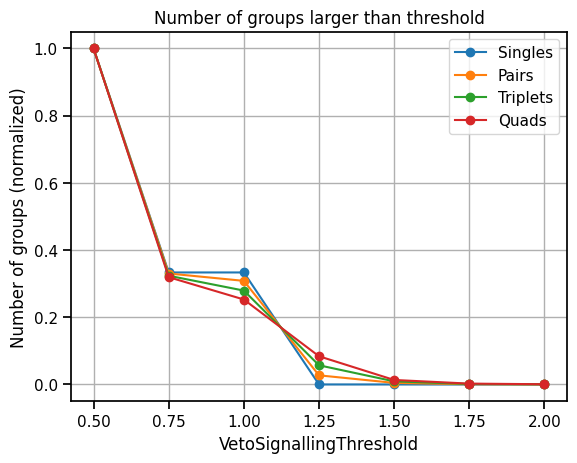

In [67]:
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]:
    plt.plot(thresholds, arr[:,0] / np.max(arr[:,0]), label=name.capitalize(), marker='o')
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of groups (normalized)')
plt.title('Number of groups larger than threshold')
plt.xticks(np.arange(0.5, 2.25, 0.25));
plt.grid();

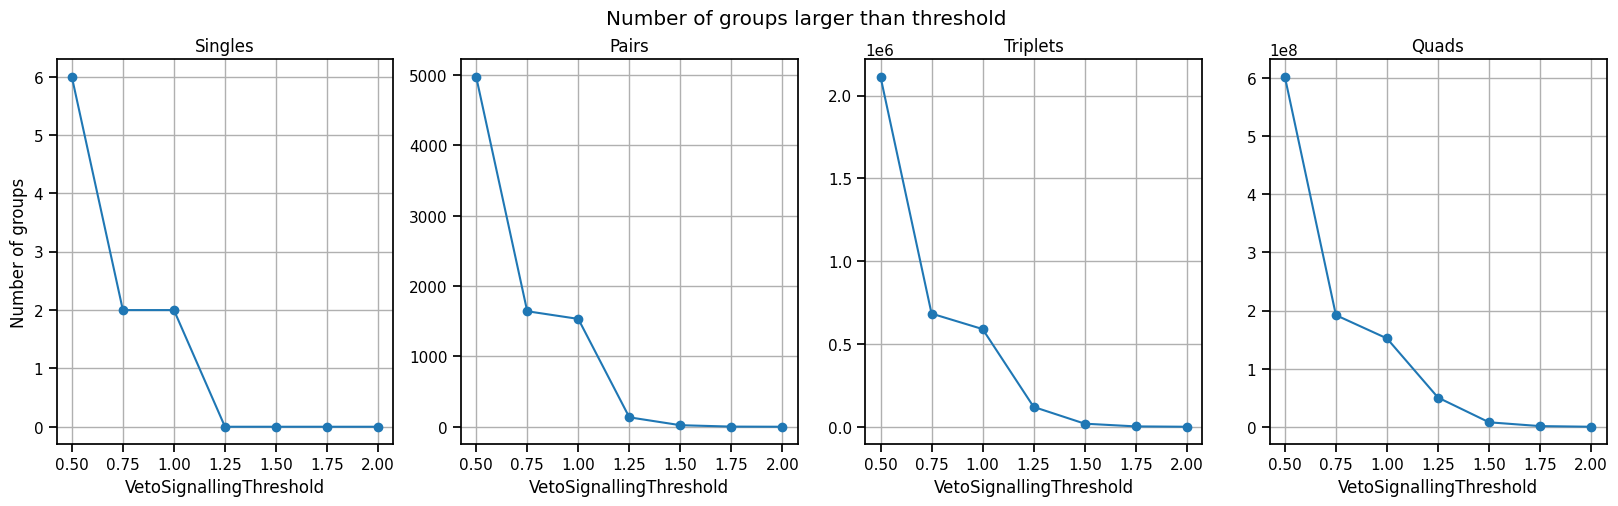

In [69]:
basesize = 5
ncols = 4
start = 0.5
step = 0.25
end = 2
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(basesize * ncols, basesize))
skip = np.sum(thresholds < start)
for i, (arr, name) in enumerate([(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]):
    axes[i].plot(thresholds[skip:], arr[skip:,0], label=name, marker='o')
    axes[i].set_xlabel('VetoSignallingThreshold')
    axes[i].set_title(name.capitalize())
    axes[i].set_xticks(np.arange(start, end+step, step))
    axes[i].grid()
axes[0].set_ylabel('Number of groups')
plt.suptitle('Number of groups larger than threshold');

##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate.

##### For example there are 590413 triplets at threshold=1.00, but each of these triplets contains one of the 12 first largest wallets. Without these first 12 wallets, large enough triplet cannot be formed.

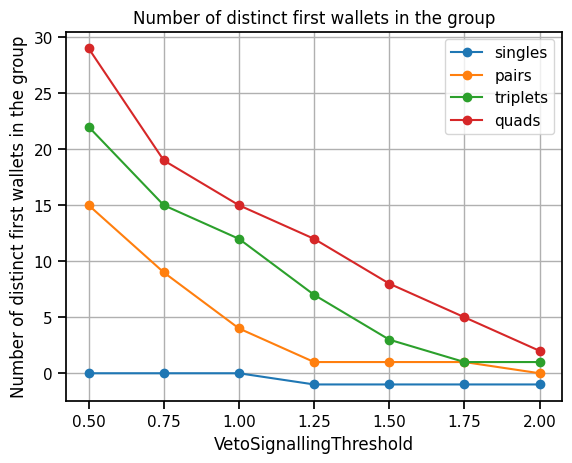

In [71]:
skip = np.sum(thresholds < start)
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]:
    plt.plot(thresholds[skip:], arr[skip:,1], label=name, marker='o')
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of distinct first wallets in the group')
plt.title('Number of distinct first wallets in the group')
plt.xticks(np.arange(start, end+step, step))
plt.grid()

display(Markdown(f"##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate."))
i = 2
display(Markdown(f"##### For example there are {triplets[i,0]} triplets at threshold={thresholds[i]:.2f}, but each of these triplets contains one of the {triplets[i,1]} first largest wallets. Without these first {triplets[i,1]} wallets, large enough triplet cannot be formed."))

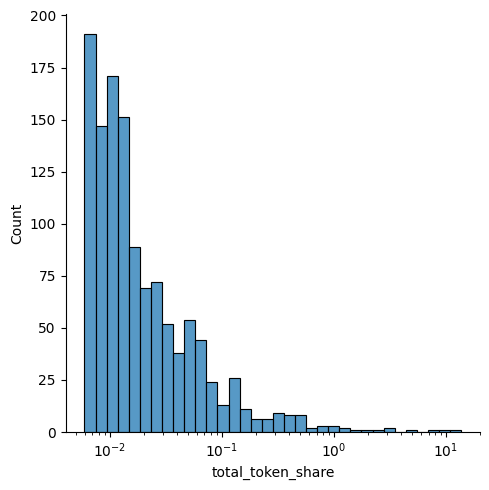

In [4]:
sns.displot(wallet_df['total_token_share'], log_scale=True)

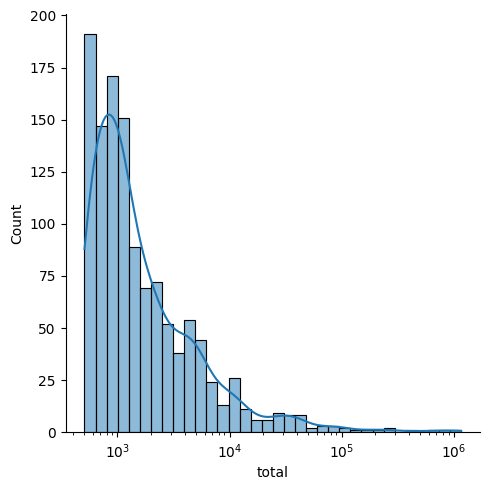

In [5]:
sns.displot(wallet_df.total, log_scale=True, kde=True)

0.8464131219739289
4278.871026
4278871025999999926272


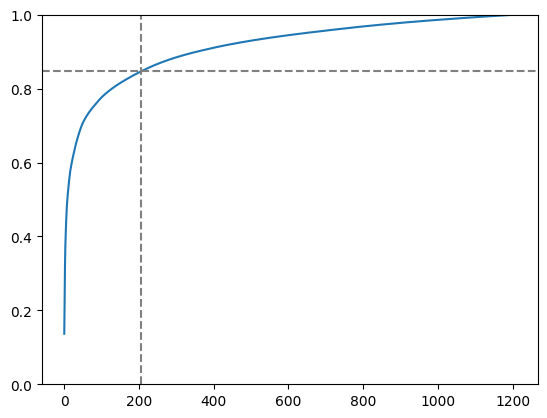

In [26]:
threshold = 0.05
balance = sorted(wallet_df.total)[::-1]
points = np.cumsum(balance) / wallet_df.total.sum()
plt.plot(points)
mask = wallet_df.total_token_share > threshold
x = np.sum(mask)
y = wallet_df[mask].total_token_share.sum() / 100
plt.plot([x, x], [0, 1], color='grey', linestyle='--')
xlim = plt.xlim()
plt.plot(xlim, [y, y], color='grey', linestyle='--')
plt.xlim(xlim)
plt.ylim(0,1)
print(y)
print(wallet_df[mask].total.min())
print(int(wallet_df[mask].total.min() * 10 **18))
# sns.displot(np.cumsum(balance), log_scale=True, kind='ecdf')

In [30]:
int(wallet_df.total.sum() * 10 ** 18)

8536242865911699582484480

In [16]:
wallet_df[mask & (wallet_df.type == 'Private')].total_token_share.sum()

26.081351101802518

In [17]:
wallet_df[mask & (wallet_df.type != 'Private')].total_token_share.sum()

51.65981109787717

In [7]:
print('mean token share:', f'{wallet_df.total_token_share.mean():.3f}%')
print('median token share:', f'{wallet_df.total_token_share.median():.3f}%')
print('mode token share:', f'{wallet_df.total_token_share.mode().iloc[0]:.3f}%')

mean token share: 0.083%
median token share: 0.013%
mode token share: 0.012%


In [73]:
threshold = 1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 1.000% of all tokens: 13
These wallets collectively hold 54.268% of all tokens


In [71]:
threshold = 0.5
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.500% of all tokens: 22
These wallets collectively hold 60.499% of all tokens


In [72]:
threshold = 0.1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.100% of all tokens: 102
These wallets collectively hold 77.741% of all tokens


In [39]:
wallet_type_summary = wallet_df.groupby('type').sum(numeric_only=True)
wallet_type_summary['wallet_count'] = wallet_df.groupby('type').count()['address']
wallet_type_summary

,stETH,wstETH,total,wallet_count
type,,,,
CEX,1.091492e+05,3.834860e+03,1.136502e+05,8
Contract,2.023537e+06,2.175870e+06,4.577356e+06,152
Custody,2.853018e+04,4.238680e+04,7.827957e+04,11
Private,2.526655e+06,1.056745e+06,3.766957e+06,1037


type
CEX            8
Contract     152
Custody       11
Private     1037
Name: wallet_count, dtype: int64
type
CEX         1.136502e+05
Contract    4.577356e+06
Custody     7.827957e+04
Private     3.766957e+06
Name: total, dtype: float64


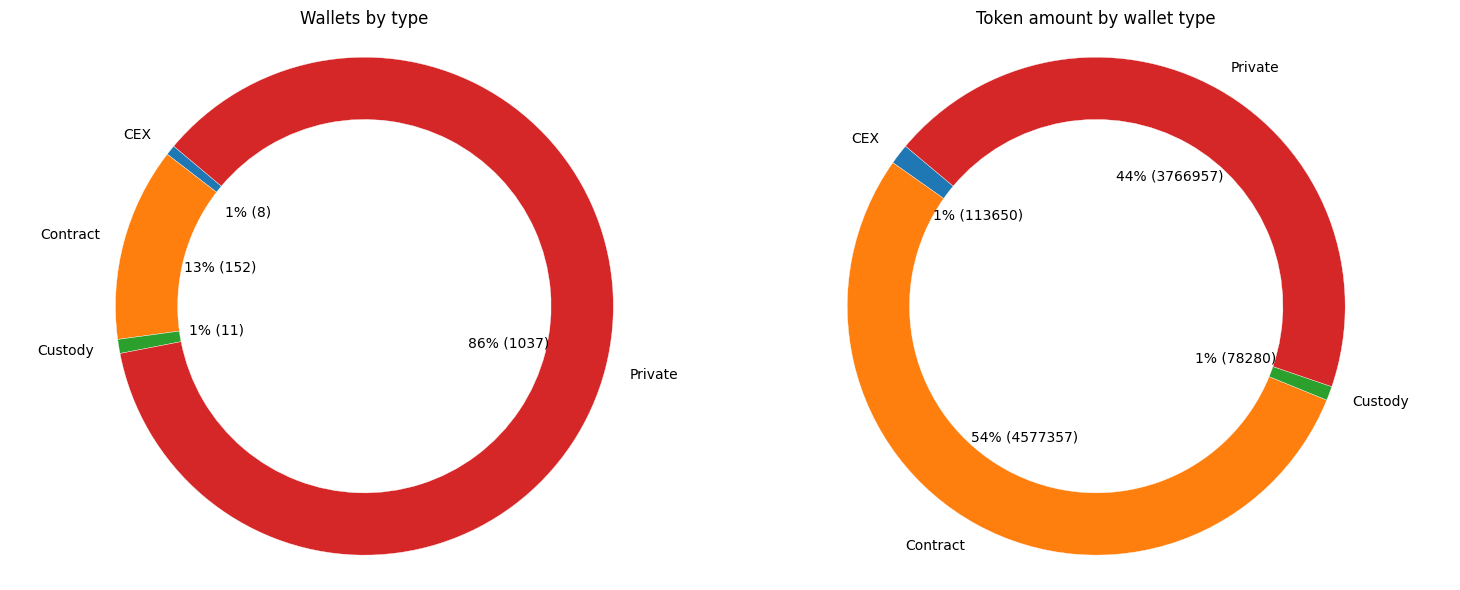

In [54]:
fig = create_donut_charts([wallet_type_summary, wallet_type_summary], ['wallet_count', 'total'], ['Wallets by type', 'Token amount by wallet type']);
fig.savefig(outpath.joinpath('wallet_type_piechart.png'))

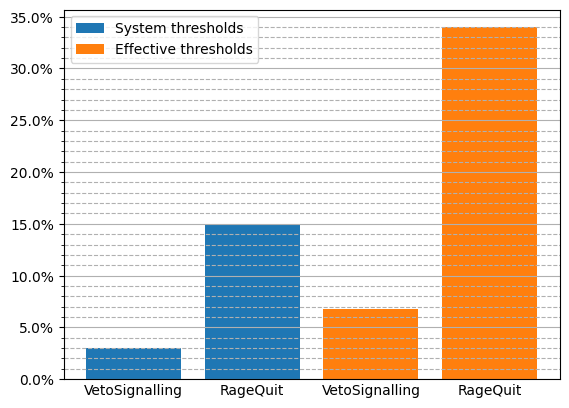

In [81]:
active_percent = wallet_type_summary['total']['Private'] / wallet_type_summary['total'].sum()

default_percents = np.array([3, 15])
plt.bar([0,1], default_percents, label='System thresholds')
plt.bar([2,3], default_percents / active_percent, label='Effective thresholds')
plt.xticks([0,1,2,3], labels=['VetoSignalling', 'RageQuit', 'VetoSignalling', 'RageQuit'])
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.gca().tick_params(axis=u'x', which=u'both',length=0)
plt.grid(True, axis='y')
plt.gca().grid(True, axis='y', which='minor', linestyle='--')
plt.legend()
plt.savefig(outpath.joinpath('effective_threshold_barchart.png'))

In [112]:
wallet_df['share'] = wallet_df.total / wallet_df.total.sum()
share_df = wallet_df[wallet_df.type == 'Private'].sort_values(by='total', ascending=False).copy()
share_df

,address,stETH,wstETH,total,label,type,protocol_type,share
3,0x98078db053902644191f93988341e31289e1c8fe,453283.812900,0.00000,453283.812900,Private Transactions Miner [0x6b764a],Private,NaN,0.053101
5,0xc329400492c6ff2438472d4651ad17389fcb843a,0.000000,210603.20510,247184.981800,clonmel.eth [0x9d91ae],Private,NaN,0.028957
8,0x48d62ed012e327faacb9c8d2a56330e215da0575,0.000000,105695.13730,124054.382600,EIP 1559 User [0x5a1f9d],Private,NaN,0.014533
9,0x3c22ec75ea5d745c78fc84762f7f1e6d82a2c5bf,9543.968864,80790.22584,104367.456900,pewpews.eth [0xa626bd],Private,NaN,0.012226
10,0x43594da5d6a03b2137a04df5685805c676def7cb,96252.516950,0.00000,96252.516950,High Balance [0x8d249e],Private,NaN,0.011276
...,...,...,...,...,...,...,...,...
1203,0x3fa930a14c9a35b6d4b3babaae395384eadd0d1f,510.591493,0.00000,510.591493,NaN,Private,NaN,0.000060
1204,0xc4652535aad91abbb4cc90f3f474e9f765003e05,509.909753,0.00000,509.909753,NaN,Private,NaN,0.000060
1205,0xa2694887f13a7bfee00824ba02b38ae848779136,509.548730,0.00000,509.548730,NaN,Private,NaN,0.000060
1206,0x3f1131d2107c6fd8d1f7f3808dfccefe5afcf6fe,509.286951,0.00000,509.286951,NaN,Private,NaN,0.000060


In [130]:
print('Only the largest wallet can overcome the VS threshold')
count0 = len(share_df) - 1
print(f'{count0} other wallets can join the largest wallet')
count1 = np.sum((share_df.drop([3,5]).share + share_df.loc[5].share) >= 0.03)
print(f'{count1} smaller wallets can overcome the VS threshold with the second largest wallet')
count2 = np.sum((share_df.drop([3,5,8]).share + share_df.loc[8].share) >= 0.03)
print(f'{count2} smaller wallets can overcome the VS threshold with the third largest wallet')
print(f'So {count0 + count1 + count2} total pairs, but they contain either the first or the second largest wallets')

Only the largest wallet can overcome the VS threshold
1036 other wallets can join the largest wallet
52 smaller wallets can overcome the VS threshold with the second largest wallet
0 smaller wallets can overcome the VS threshold with the third largest wallet
So 1088 total pairs, but they contain either the first or the second largest wallets


### Todo count triplets in the same manner. Meaning count triplets with the second largest wallet and wallets not in the count1, the third largest wallet

In [156]:
share_df_d = share_df.drop([3,5])
mask = (share_df_d.share + share_df.loc[5].share) < 0.03

count3 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[99].share + share_df_d[mask].drop([99]).share) >= 0.03)
count4 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[100].share + share_df_d[mask].drop([99,100]).share) >= 0.03)
count5 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[101].share + share_df_d[mask].drop([99,100, 101]).share) >= 0.03)
count6 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[105].share + share_df_d[mask].drop([99,100, 101,105]).share) >= 0.03)
count7 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[106].share + share_df_d[mask].drop([99,100, 101,105,106]).share) >= 0.03)
count8 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[107].share + share_df_d[mask].drop([99,100, 101,105,106,107]).share) >= 0.03)
count9 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[109].share + share_df_d[mask].drop([99,100, 101,105,106,107,109]).share) >= 0.03)
count10 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[111].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111]).share) >= 0.03)
count11 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[113].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113]).share) >= 0.03)
count12 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[115].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113,115]).share) >= 0.03)
print(count3, count4, count5, count6, count7, count8, count9, count10, count11, count12)

982 981 980 634 361 350 321 290 245 232


In [149]:
share_df_d[mask].head(10)

,address,stETH,wstETH,total,label,type,protocol_type,share
99,0x1a5213554ac2f7056c554fb19416ff9738e165ba,8846.902577,0.000000,8846.902577,haos.eth [0x1a5213],Private,NaN,0.001036
100,0x98ec0508e134dfee2992e42577696625768be437,8757.369407,0.000000,8757.369407,Token Millionaire [0x98ec05],Private,NaN,0.001026
101,0xa5d223c176daab154a3134369d1c0478c5e6fecf,0.000000,7305.219814,8574.136496,10248.eth* [0xa5d223],Private,NaN,0.001004
105,0xb3668730e4a8abe282a6d471c75baf75557ffff3,0.000000,6885.493147,8081.503306,Token Millionaire [0x4992c5],Private,NaN,0.000947
106,0x46cd2870894a9a7d5eedbb40997d994fa8a058df,7658.563187,0.000000,7658.563187,Token Millionaire [0x46cd28],Private,NaN,0.000897
107,0xfc09d8c9a63670702c2de876ff95608ab971dcd6,7621.633895,0.000000,7621.633895,Token Millionaire [0xfc09d8],Private,NaN,0.000893
109,0x4a240f0ee138697726c8a3e43efe6ac3593432cb,0.000000,6412.794919,7526.697396,Gnosis Safe MultiSig,Private,NaN,0.000882
111,0x0685c5aed38f038d984e8dc7dc8ad8783f166f35,0.000000,6300.000000,7394.310000,Token Millionaire,Private,NaN,0.000866
113,0xa3726bedfd1a8aa696b9b4581277240028c4314b,0.000000,6121.661852,7184.994516,Token Millionaire,Private,NaN,0.000842
115,0x720d8790666bd40b9ca289cbe73cb1334f0ae7e3,7101.672500,0.000000,7101.672500,Gnosis Safe MultiSig,Private,NaN,0.000832


So there are much more triplets that can put the system into VetoSignalling. TODO exaustive counting

In [40]:
data = np.random.normal(size=(1000, 10000))


In [41]:
print(np.std(np.mean(data > 0, axis=1)))
print(np.std(data > 0, axis=(0,1)))

0.0049855416395814
0.4999999552254378
